# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt 
import datetime
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model, feature_selection, model_selection,metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

% matplotlib inline



In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Dataset Exploration

**1) Portfolio Dataset**

In [3]:
# explore the portfolio
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.shape

(10, 6)

In [5]:
# checking for the existence of missing values(NaNs)
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [6]:
# values in offer_type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [7]:
# checking for duplicates
portfolio.columns.duplicated().sum()

0

**Clean Portfolio Dataset**

In [8]:
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    #offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels'], axis=1, inplace=True) #'offer_type'
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    #cleaned_portfolio = pd.concat([cleaned_portfolio, portfolio], axis=1, sort=False) # changed offer_type to portfolio
    
    # renaming 'offer_id' column to id.
    cleaned_portfolio.rename(columns={'id':'offer_id'},inplace=True)

    
    return cleaned_portfolio

In [9]:
cleaned_portfolio = clean_portfolio(portfolio)

In [10]:
cleaned_portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


**2) Profile Dataset**

In [11]:
# explore the profile
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
profile.shape

(17000, 5)

In [13]:
# checking for the existence of missing values(NaNs)
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [14]:
# checking for duplicates
portfolio.columns.duplicated().sum()

0

In [15]:
# checking the number unique customers
profile['id'].nunique()

17000

In [16]:
profile.columns.duplicated().sum()

0

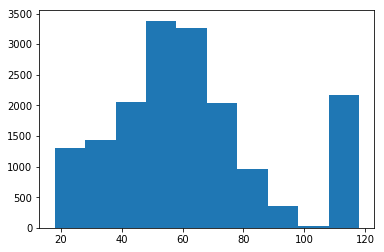

In [17]:
plt.hist(profile['age'], bins=10);


In [18]:
# Age 118
profile[profile['age']==118].count()


age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [19]:
# checking the number of Male and Famale customers 
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [20]:
# getting the statitical summary of the 'income' column
profile['income'].describe()


count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

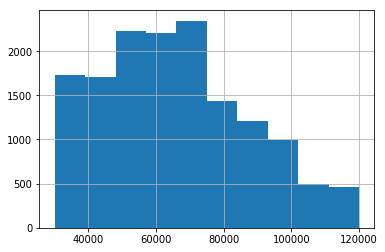

In [21]:
# checking the distribution of 'income' column
profile['income'].hist();


In [22]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    profile.rename(columns={'id':'customer_id'},inplace=True)
    
    
    # changing the datatype of 'age' and 'income' columns to 'int'
    profile[['age','income']] = profile[['age','income']].astype(int)
    
    # creating a new column representing the age group to which the customer belongs 
    profile['age_group'] = pd.cut(profile['age'], bins=[17, 22, 35, 60, 103],labels=['teenager', 'young-adult', 'adult', 'elderly'])

    # income range
    profile['income_range'] = pd.cut(profile['income'], bins=[29999, 60000, 90000, 120001],labels=['average', 'above-average', 'high'])

    # format datetime
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

    profile['membership_year'] = profile['became_member_on'].dt.year
    
    
    # create member profile
    
    profile['member_type'] = pd.cut(profile['memberdays'], bins=[390, 1000, 1600, 2500],labels=['new', 'regular', 'loyal'])
 
    
    return profile

In [23]:
cleaned_profile = clean_profile(profile)


In [24]:
cleaned_profile.head()


,age,became_member_on,gender,customer_id,income,memberdays,age_group,income_range,membership_year,member_type
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,1255,adult,high,2017,regular
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,1322,elderly,high,2017,regular
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000,970,elderly,above-average,2018,new
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000,1046,elderly,average,2018,regular
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000,1136,adult,average,2017,regular


In [25]:
cleaned_profile.describe()


,age,income,memberdays,membership_year
count,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,1401.478988,2016.620169
std,17.383705,21598.299410,419.205158,1.198245
min,18.000000,30000.000000,879.000000,2013.000000
25%,42.000000,49000.000000,1087.000000,2016.000000
50%,55.000000,64000.000000,1237.000000,2017.000000
75%,66.000000,80000.000000,1676.000000,2017.000000
max,101.000000,120000.000000,2702.000000,2018.000000


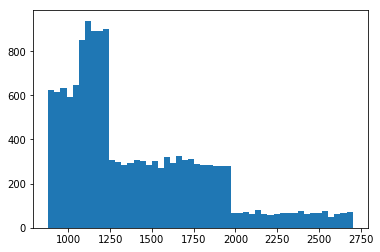

In [26]:
plt.hist(cleaned_profile['memberdays'], bins=50);


**3) Trascipt Dataset**

In [27]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [28]:
transcript.shape

(306534, 4)

In [29]:
# checking for duplicates
transcript.columns.duplicated().sum()

0

In [30]:
# checking for the existence of missing values(NaNs)
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [31]:
# checking the count of each event type
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [32]:
# select one user and explore the transcript records
transcript[transcript['person']=='9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,event,person,time,value
36,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
27850,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,42,{'amount': 21.55}
44327,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,114,{'amount': 32.87}
51350,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,156,{'amount': 19.99}
65854,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,168,{'amount': 20.97}
81403,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,204,{'amount': 31.09}
110866,offer received,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


In [33]:
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    transcript_value = pd.DataFrame([x for x in transcript['value']])


    transcript_value.columns = transcript_value.columns.str.replace('offer id', 'offer_id')
    s = transcript_value.stack()
    transcript_value = s.unstack()

    offer = pd.concat([transcript,transcript_value], axis=1)


    # rename person column to customer_id
    offer.rename(columns={'person':'customer_id'},inplace=True)
    
    
    return offer

In [34]:
offer = clean_transcript(transcript)


In [35]:
offer.head()


,event,customer_id,time,value,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


I am going to create a table with 1 row per user with information about whether offee was received, viewed and completed.

In [36]:
# created 4 transactional tables

# table 1

# offered viewed

offer_viewed = offer[offer.event == 'offer viewed']

# rename time to time_received
offer_viewed.rename(columns={'time':'time_viewed'}, inplace=True)

# table 2

# offered completed

offer_completed = offer[offer.event == 'offer completed']

# rename time to time_received
offer_completed.rename(columns={'time':'time_completed'}, inplace=True)

# table 3

# offered transaction

offer_transaction = offer[offer.event == 'transaction']

# rename time to time_received
offer_transaction.rename(columns={'time':'time_transaction'}, inplace=True)

# table 4

# offered viewed

offer_received = offer[offer.event == 'offer received']

# rename time to time_received
offer_received.rename(columns={'time':'time_received'}, inplace=True)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [37]:
offer_viewed.head()



,event,customer_id,time_viewed,value,amount,offer_id,reward
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,NaN


In [38]:
offer_viewed = offer_viewed.drop(['amount','reward','value'],axis=1)

In [39]:
offer_viewed.head()


,event,customer_id,time_viewed,offer_id
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


In [40]:
offer_completed = offer_completed.drop(['value','amount'], axis=1)


In [41]:

offer_completed.head()

,event,customer_id,time_completed,offer_id,reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [42]:
offer_transaction = offer_transaction.drop(['value','offer_id', 'reward'], axis=1)


In [43]:
offer_transaction.head()

,event,customer_id,time_transaction,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [44]:
# drop columns from tables

offer_received = offer_received.drop(['value', 'amount', 'reward'],axis=1)
#'value', 'amount', 'reward'

In [45]:
offer_received.head()

,event,customer_id,time_received,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [46]:
# group data to get one row per customer per offer

## offer received

offer_received.groupby(['customer_id','offer_id']).event.count()\
           .reset_index().sort_values('event',ascending=False).head(10)


offer_received = offer_received.groupby(['event','customer_id','offer_id'])['time_received']\
                      .count().reset_index().rename(columns={'time_received':'received_count'})


In [47]:
offer_received.head()

,event,customer_id,offer_id,received_count
0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,offer received,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


In [48]:

## offer viewed
offer_viewed.groupby(['customer_id','offer_id']).event.count()\
           .reset_index().sort_values('event',ascending=False).head(10)

offer_viewed = offer_viewed.groupby(['event','customer_id','offer_id'])['time_viewed']\
                      .count().reset_index().rename(columns={'time_viewed':'viewed_count'})


In [49]:

## transaction
offer_transaction.groupby('customer_id').amount.sum().reset_index().sort_values('amount',ascending=False).head()



,customer_id,amount
3929,3c8d541112a74af99e88abbd0692f00e,1608.69
15693,f1d65ae63f174b8f80fa063adcaa63b7,1365.66
11422,ae6f43089b674728a50b8727252d3305,1327.74
6366,626df8678e2a4953b9098246418c9cfa,1321.42
7492,73afdeca19e349b98f09e928644610f8,1319.97


In [50]:
# offer completed
offer_completed.groupby(['customer_id','offer_id']).time_completed.count().reset_index()\
         .sort_values('time_completed',ascending=False).head(10)

offer_completed = offer_completed.groupby(['event','customer_id','offer_id','reward'])['time_completed']\
                      .count().reset_index().rename(columns={'time_completed':'completed_count'})

In [51]:
offer_completed.rename(columns={'reward':'reward_completed'}, inplace=True)
offer_completed.head()


,event,customer_id,offer_id,reward_completed,completed_count
0,offer completed,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,1
1,offer completed,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1
2,offer completed,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1
3,offer completed,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,1
4,offer completed,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1


In [52]:
# merge transcript

offer_analysis = offer_received.merge(offer_viewed, on = ['customer_id','offer_id'], how='left')


offer_analysis = offer_analysis.merge(offer_completed, on = ['customer_id','offer_id'], how='left')
offer_analysis.rename(columns={'event_x':'event_received','event_y':'event_viewed','event':'event_completed'}
                           ,inplace=True)
offer_analysis.head()

,event_received,customer_id,offer_id,received_count,event_viewed,viewed_count,event_completed,reward_completed,completed_count
0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,NaN,NaN,offer completed,2.0,1.0
1,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,offer viewed,1.0,NaN,NaN,NaN
2,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,offer viewed,1.0,NaN,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,offer viewed,1.0,offer completed,5.0,1.0
4,offer received,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,offer viewed,1.0,offer completed,2.0,1.0


In [53]:
# add portfolio and profile

offer_analysis = offer_analysis.merge(cleaned_portfolio, on ='offer_id', how = 'left')

offer_analysis.head()

,event_received,customer_id,offer_id,received_count,event_viewed,viewed_count,event_completed,reward_completed,completed_count,difficulty,duration,offer_type,reward,web,email,mobile,social
0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,NaN,NaN,offer completed,2.0,1.0,10,168,discount,2,1,1,1,0
1,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,offer viewed,1.0,NaN,NaN,NaN,0,96,informational,0,1,1,1,0
2,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,offer viewed,1.0,NaN,NaN,NaN,0,72,informational,0,0,1,1,1
3,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,offer viewed,1.0,offer completed,5.0,1.0,5,120,bogo,5,1,1,1,1
4,offer received,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,offer viewed,1.0,offer completed,2.0,1.0,10,240,discount,2,1,1,1,1


In [54]:
offer_analysis = offer_analysis.merge(cleaned_profile, on='customer_id', how='left')

offer_analysis.event_viewed.fillna("not viewed", inplace=True)
offer_analysis.event_completed.fillna("not completed", inplace=True)

offer_analysis.viewed_count.fillna(0, inplace=True)
offer_analysis.completed_count.fillna(0, inplace=True)

offer_analysis.head()


,event_received,customer_id,offer_id,received_count,event_viewed,viewed_count,event_completed,reward_completed,completed_count,difficulty,...,social,age,became_member_on,gender,income,memberdays,age_group,income_range,membership_year,member_type
0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,not viewed,0.0,offer completed,2.0,1.0,10,...,0,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
1,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,offer viewed,1.0,not completed,NaN,0.0,0,...,0,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
2,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,offer viewed,1.0,not completed,NaN,0.0,0,...,1,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
3,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,offer viewed,1.0,offer completed,5.0,1.0,5,...,1,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
4,offer received,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,offer viewed,1.0,offer completed,2.0,1.0,10,...,1,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular


In [55]:
offer_analysis.head()

,event_received,customer_id,offer_id,received_count,event_viewed,viewed_count,event_completed,reward_completed,completed_count,difficulty,...,social,age,became_member_on,gender,income,memberdays,age_group,income_range,membership_year,member_type
0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,not viewed,0.0,offer completed,2.0,1.0,10,...,0,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
1,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,offer viewed,1.0,not completed,NaN,0.0,0,...,0,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
2,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,offer viewed,1.0,not completed,NaN,0.0,0,...,1,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
3,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,offer viewed,1.0,offer completed,5.0,1.0,5,...,1,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
4,offer received,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,offer viewed,1.0,offer completed,2.0,1.0,10,...,1,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular


In [56]:
print(offer_analysis.event_received.unique())


['offer received']


**Portfolio**

The dataset has 6 columns and 10 rows.
This dataset has no null values nor duplicates.
There are three types of offers : 'bogo'(Buy One Get One free), 'informational' and 'discount'.

**Profile**

The dataset has 5 columns and 17,000 rows.
The dataset has no duplicated rows.
The dataset has 2175 missing values on each of: ‘gender’, ’income’ variables.
The customers ages range from 18 to 118 with 2175 customers registered at age 118
Exploring and visualizing three variables in this dataset: ‘gender’,’income’ and ’age’, allowed me to get the following conclusion:
The missing values in 'gender' and ‘income’ variables are for 2175 customers registered at age 118. In other words, customers at age 118 has no registered ‘gender’ and ‘income’. 
Customers income ranges from 30,000 and 120,000 with most of the customers’ incomes fall between 50,000 and 75,0000.
According to the available data, There are three ‘gender’ categories into which the customers falls in ( M, F and O).

**Transcript**

The dataset has 4 columns and 306,534 rows.
The dataset has no duplicated rows nor missing values.
There are four types of events in this dataset: ‘transaction’, ’ offer received’, ‘offer viewed’ and ‘offer completed’.
All the events that are classified as ‘transaction’ do not have an ‘offerid’ within its ‘value’ column.

## Data Exploration

**1) No of Offers**

In [57]:

offer_analysis.groupby('offer_type').offer_id.count()


offer_type
bogo             25321
discount         25316
informational    12651
Name: offer_id, dtype: int64

**2) Offers by age groups**

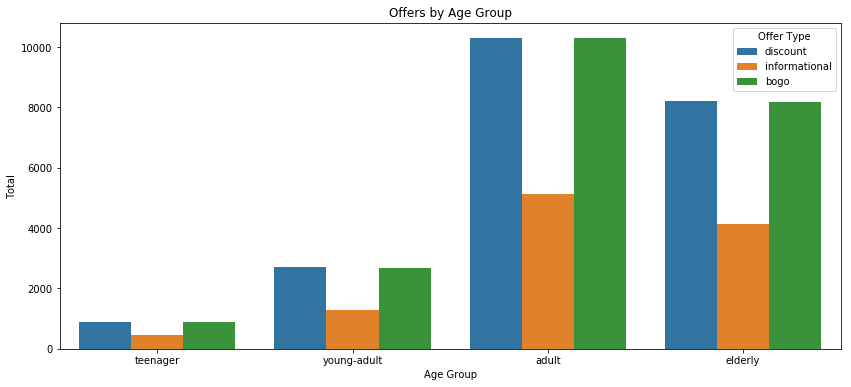

In [58]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_group", hue="offer_type", data=offer_analysis)
plt.title('Offers by Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

**3) Offer by Gender**

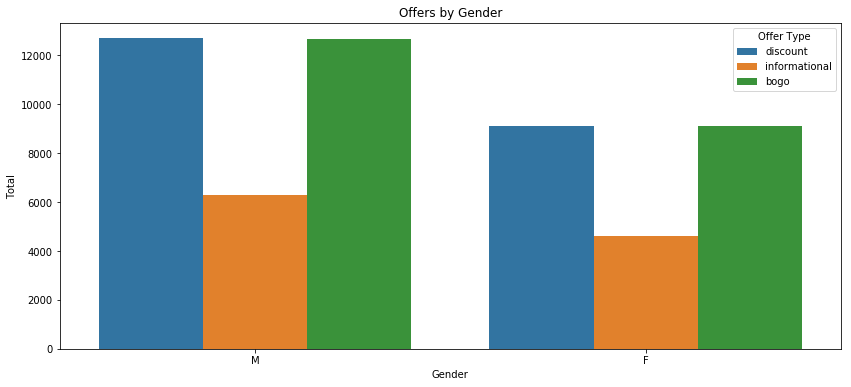

In [59]:

plt.figure(figsize=(14, 6))
g = sns.countplot(x="gender", hue="offer_type", data= offer_analysis[offer_analysis["gender"] != 'O'])
plt.title('Offers by Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

**4) Income by gender**

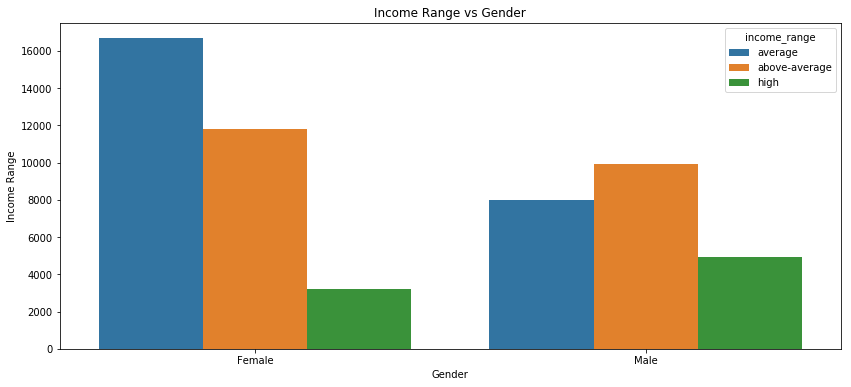

In [60]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="gender", hue="income_range", data= offer_analysis[offer_analysis["gender"] != 'O'])
plt.title('Income Range vs Gender')
plt.ylabel('Income Range')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

**5) No of Profiles in Each Year**

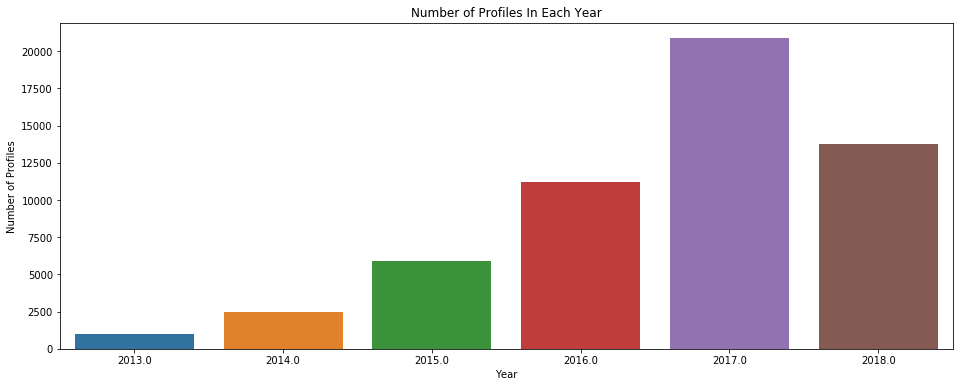

In [61]:
plt.figure(figsize=(16, 6))
sns.countplot(offer_analysis['membership_year'])
plt.title('Number of Profiles In Each Year')
plt.ylabel('Number of Profiles')
plt.xlabel('Year')
plt.xticks()
plt.show();


In [62]:
offer_analysis.head()

,event_received,customer_id,offer_id,received_count,event_viewed,viewed_count,event_completed,reward_completed,completed_count,difficulty,...,social,age,became_member_on,gender,income,memberdays,age_group,income_range,membership_year,member_type
0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,not viewed,0.0,offer completed,2.0,1.0,10,...,0,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
1,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,offer viewed,1.0,not completed,NaN,0.0,0,...,0,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
2,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,offer viewed,1.0,not completed,NaN,0.0,0,...,1,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
3,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,offer viewed,1.0,offer completed,5.0,1.0,5,...,1,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular
4,offer received,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,offer viewed,1.0,offer completed,2.0,1.0,10,...,1,33.0,2017-04-21,M,72000.0,1340.0,young-adult,above-average,2017.0,regular


Rate of viewed offers to total offers:
 1.0    0.652841
0.0    0.223628
2.0    0.112107
3.0    0.010713
4.0    0.000648
5.0    0.000063
Name: viewed_count, dtype: float64


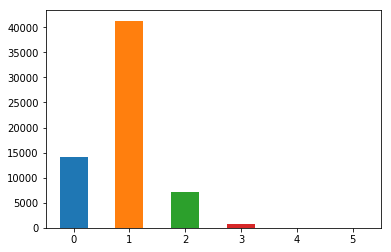

In [63]:
offer_analysis.groupby('viewed_count').event_viewed.count().reset_index().event_viewed.plot.bar(rot=0)

print("Rate of viewed offers to total offers:\n", 
      offer_analysis.viewed_count.value_counts()/offer_analysis.shape[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


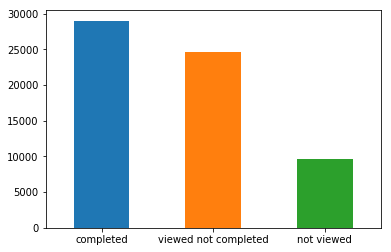

In [64]:
offer_analysis['event'] = 'not viewed'
offer_analysis['event'][offer_analysis.event_viewed == 'offer viewed'] = 'viewed not completed'
offer_analysis['event'][offer_analysis.event_completed == 'offer completed'] = 'completed'
offer_analysis.event.value_counts().plot.bar(rot=0)

In [65]:
offer_analysis.event.value_counts()


completed               28996
viewed not completed    24675
not viewed               9617
Name: event, dtype: int64

## Data Prep for Modelling

In [66]:
# prepare data for model

df_model = offer_analysis[['received_count','difficulty','duration','offer_type',
                                'email','mobile','social','web','gender',
                                 'event_completed', 'income_range', 'member_type', 'age_group']]
df_model.isnull().sum()

received_count        0
difficulty            0
duration              0
offer_type            0
email                 0
mobile                0
social                0
web                   0
gender             8066
event_completed       0
income_range       8066
member_type        9423
age_group          8066
dtype: int64

In [67]:
# convert age group to integer
labels_age_group = df_model['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
print(replace_map_comp_age_group)

df_model.replace(replace_map_comp_age_group, inplace=True)



{'age_group': {'teenager': 1, 'young-adult': 2, 'adult': 3, 'elderly': 4}}


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [68]:
#convert income range to integer

labels_income_group = df_model['income_range'].astype('category').cat.categories.tolist()
replace_map_comp_income_group = {'income_range' : {k: v for k,v in zip(labels_income_group,list(range(1,len(labels_income_group)+1)))}}
print(replace_map_comp_income_group)

df_model.replace(replace_map_comp_income_group, inplace=True)


{'income_range': {'average': 1, 'above-average': 2, 'high': 3}}


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [69]:
#convert offer type to integer
labels_offer_group = df_model['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_group = {'offer_type' : {k: v for k,v in zip(labels_offer_group,list(range(1,len(labels_offer_group)+1)))}}
print(replace_map_comp_offer_group)

df_model.replace(replace_map_comp_offer_group, inplace=True)


{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [70]:
#convert gender range to integer
labels_gender_group = df_model['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender_group = {'gender' : {k: v for k,v in zip(labels_gender_group,list(range(1,len(labels_gender_group)+1)))}}
print(replace_map_comp_gender_group)

df_model.replace(replace_map_comp_gender_group, inplace=True)

{'gender': {'F': 1, 'M': 2, 'O': 3}}


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [71]:
#convert member type to integer
labels_member_type_group = df_model['member_type'].astype('category').cat.categories.tolist()
replace_map_comp_member_type_group = {'member_type' : {k: v for k,v in zip(labels_member_type_group,list(range(1,len(labels_member_type_group)+1)))}}
print(replace_map_comp_member_type_group)

df_model.replace(replace_map_comp_member_type_group, inplace=True)

{'member_type': {'new': 1, 'regular': 2, 'loyal': 3}}


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [72]:
# fill NA
df_model.event_completed.fillna("not completed", inplace=True)
# convert to binary
df_model['event_completed'] = df_model.event_completed.apply(lambda x: 1 if x=='offer completed' else 0)

df_model.head()


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,received_count,difficulty,duration,offer_type,email,mobile,social,web,gender,event_completed,income_range,member_type,age_group
0,1,10,168,2,1,1,0,1,2.0,1,2.0,2.0,2.0
1,1,0,96,3,1,1,0,1,2.0,0,2.0,2.0,2.0
2,1,0,72,3,1,1,1,0,2.0,0,2.0,2.0,2.0
3,1,5,120,1,1,1,1,1,2.0,1,2.0,2.0,2.0
4,1,10,240,2,1,1,1,1,2.0,1,2.0,2.0,2.0


In [73]:
df_model = df_model[df_model.gender.notnull()].reset_index(drop=True)
df_model = df_model[df_model.member_type.notnull()].reset_index(drop=True)


In [74]:
df_model[['difficulty','duration','gender','income_range', 'member_type', 'age_group']] = df_model[['difficulty','duration', 'gender','income_range', 'member_type', 'age_group']].astype(int)

In [75]:
# features and label for modelling

features = df_model.drop('event_completed', axis=1)
labels = df_model.event_completed

In [76]:
labels.value_counts()


1    27297
0    26568
Name: event_completed, dtype: int64

In [77]:
features_encode = features


In [78]:
# normalizing some numerical values 
scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(features_encode)
features_encode = scaler.transform(features_encode)


## Model

In [79]:
X_train, X_test, y_train, y_test = train_test_split(features_encode, labels, test_size=0.2, random_state=42)


In [80]:
print("Training Features Shape: ", X_train.shape)
print("Training Labels Shape: ", y_train.shape)
print("Testing Features Shape: ", X_test.shape)
print("Testing Labels Shape: ", y_test.shape)

Training Features Shape:  (43092, 12)
Training Labels Shape:  (43092,)
Testing Features Shape:  (10773, 12)
Testing Labels Shape:  (10773,)


In [81]:
# decission tree
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

predicted = dt.predict(X_test)
report = classification_report(y_test, predicted)
print(report)


             precision    recall  f1-score   support

          0       0.81      0.69      0.74      5315
          1       0.74      0.84      0.79      5458

avg / total       0.77      0.77      0.77     10773



In [82]:
kn = KNeighborsClassifier()

kn.fit(X_train, y_train)

predicted = dt.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.81      0.69      0.74      5315
          1       0.74      0.84      0.79      5458

avg / total       0.77      0.77      0.77     10773



In [83]:
# Naive Bayes
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 

predicted = gnb.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.84      0.55      0.67      5315
          1       0.67      0.90      0.77      5458

avg / total       0.76      0.73      0.72     10773



In [84]:
# Random Forest
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.84      0.55      0.67      5315
          1       0.67      0.90      0.77      5458

avg / total       0.76      0.73      0.72     10773



<Container object of 12 artists>

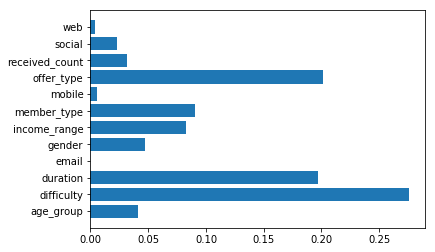

In [85]:
rf.feature_importances_
feature_names = list(df_model.drop('event_completed',axis=1).columns)

plt.barh(feature_names, rf.feature_importances_)


In [86]:
# Logistic Regression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

predicted = logreg.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.78      0.68      0.72      5315
          1       0.72      0.81      0.76      5458

avg / total       0.75      0.75      0.74     10773



In [87]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    ]

In [88]:
for model in MLA:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(type(model).__name__)
    print(classification_report(y_test, y_pred))
    print("ROC score: ", roc_auc_score(y_test, y_pred))

AdaBoostClassifier
             precision    recall  f1-score   support

          0       0.81      0.68      0.74      5315
          1       0.73      0.85      0.78      5458

avg / total       0.77      0.76      0.76     10773

ROC score:  0.762366478026
BaggingClassifier
             precision    recall  f1-score   support

          0       0.81      0.68      0.74      5315
          1       0.73      0.85      0.79      5458

avg / total       0.77      0.77      0.76     10773

ROC score:  0.764223298277
ExtraTreesClassifier
             precision    recall  f1-score   support

          0       0.81      0.69      0.74      5315
          1       0.74      0.84      0.79      5458

avg / total       0.77      0.77      0.77     10773

ROC score:  0.765978237301
GradientBoostingClassifier
             precision    recall  f1-score   support

          0       0.82      0.67      0.74      5315
          1       0.73      0.86      0.79      5458

avg / total       0.78      

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/opt/conda/lib/python3.6/si

GaussianNB
             precision    recall  f1-score   support

          0       0.84      0.55      0.67      5315
          1       0.67      0.90      0.77      5458

avg / total       0.76      0.73      0.72     10773

ROC score:  0.725901358428
KNeighborsClassifier
             precision    recall  f1-score   support

          0       0.74      0.70      0.72      5315
          1       0.72      0.76      0.74      5458

avg / total       0.73      0.73      0.73     10773

ROC score:  0.730280027729
DecisionTreeClassifier
             precision    recall  f1-score   support

          0       0.81      0.69      0.74      5315
          1       0.74      0.84      0.79      5458

avg / total       0.77      0.77      0.77     10773

ROC score:  0.766072310679
ExtraTreeClassifier
             precision    recall  f1-score   support

          0       0.81      0.69      0.74      5315
          1       0.74      0.84      0.79      5458

avg / total       0.77      0.77      

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Conclusion
The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has mainly two steps. First, I combined offer portfolio, customer profile, and transaction data. Second, I assessed the accuracy and F1-score of few models of supervised learning. This analysis suggests that a decision tree model has the best test data accuracy (0.77) and F1-score (0.77).

## Improvements

The performance of models can be still improved by analysing features which impacts an offer's success rate as a function of offer difficulty, duration, and reward. 
We could also remove users who haven't seen the offer from the dataset and only limit it to those how did use or didn't use the offer to improve final model. We also had to deal with duplicates and missing values in transaction dataset. Rather than dropping them, we should investigate whether there is a better way to deal with them.
We also aggregated the dataset per offer. Another way how to look at it is from customer perspective. Perhaps some customers are more likely to use the offer no matter what the offer is.
We could also reach out to Starbucks and see whether there are other customer metrics we could use as not every metric is significant for the model.